## Import Packages

In [20]:
import json, re
from tqdm import tqdm_notebook as tqdm
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from textblob import TextBlob
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import itertools
import matplotlib.colors as mcolors

### LDA Topic Modeling
import gensim, spacy, logging, warnings
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from wordcloud import WordCloud

plt.style.use('seaborn-pastel')
sns.color_palette('pastel')

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

## Import Data

In [3]:

in_paths = ['../microbiome_patents', '../probiotic_patents']
if (len(in_paths) == 1) or (isinstance(in_paths, str)):
    with open(f'{in_path}.json', 'r') as f:
        patent_data = json.load(f)
elif len(in_paths) > 1:
    patent_data = {}
    for in_path in in_paths:
        with open(f'{in_path}.json', 'r') as f:
            tmp_data = json.load(f)
        patent_data.update(tmp_data)

patent_ids = [i for i in list(patent_data.keys())]
terms = [i.split('_')[0] for i in patent_ids]

print(f'Terms found in the {len(patent_ids)} loaded patents include: {set(terms)}\n')
for term in set(terms):
    term_ids = [i.split('_')[1] for i in patent_ids if i.split('_')[0] == term]
    print(f'Minimum {term} patent result number : {min(term_ids)}\nMaximum {term} patent result number : {max(term_ids)}')


Terms found in the 2182 loaded patents include: {'microbiome', 'probiotic'}

Minimum microbiome patent result number : 000001
Maximum microbiome patent result number : 001084
Minimum probiotic patent result number : 000001
Maximum probiotic patent result number : 001100


## Publication Dates

There dates will get used throughout the notebook to look at features over time.

In [4]:
### Taken from other notebook
pub_dates = [i['publication_date'] for i in patent_data.values() if i['publication_date'] != '']
pub_dates = [i.replace('rch', 'Mar').replace('ary', 'Feb').replace('ust', 'Aug') for i in pub_dates]
pub_dates = [i.replace('ril', 'Apr').replace('une', 'Jun').replace('uly', 'Jul') for i in pub_dates]
### One could argue this substitution but the effect is minor
pub_dates = [i.replace('ber', 'Oct') for i in pub_dates]
#pub_dates = [i.replace('ber', 'Nov') for i in pub_dates]
pub_dates = [dt.datetime.strptime(i, '%b %d, %Y') for i in pub_dates]
pub_quarters = [str(i.year) + '-' + f'{pd.Timestamp(i).quarter}' for i in pub_dates]

## Abstracts

### Text pre-processing

In [10]:
abstracts = [i['abstract'].lower() for i in patent_data.values()]
abstracts = [re.sub('[,;#()-:]|(\.)|(\.$)', '', i) for i in abstracts]
abstracts[:5]

['a sporeforming bacillus species and more particularly a bacillus subtilis strain identified as mb is provided compositions comprising the mb strain methods of making products comprising the same and methods of using the same are also provided',
 'the present invention concerns novel probiotic compositions that increase nitrate and nitritereduction in animals such as ruminants the present invention thus provides compositions and methods for reducing nitratenitrite toxicity in such animals or prophylactically protecting such animals from the effects of toxicity such as methemoglobinemia a novel strain of an unspeciated bacterial strain related to paenibacillus species with nitrate and nitritereducing capabilities is described in conjunction with nitratesupplemented diets the probiotics of the present invention can also be utilized to reduce methanogenesis in livestock furthermore the probiotic compositions of the present invention can be used to reduce the number and kind of foodborne 

### Word / N-Gram Tokenization

In [38]:
stop_words = set(stopwords.words('english')) 
fil_abstracts = []
corpus = []
ngrams_2 = []
ngrams_3 = []
st = PorterStemmer()
### Loop through abstracts and build 1-gram, 2-gram and 3-gram lists
for abstract in tqdm(abstracts, total=len(abstracts)):
    word_tokens = word_tokenize(abstract)
    ### Stem each word and remove stop words
    filtered_abstract = [st.stem(w) for w in word_tokens if not w in stop_words]
    
    ### Append each list of filtered words from each abstract to a `fil_abstracts` for later
    fil_abstracts.append(filtered_abstract)
    
    ### Create n-gram objects using TextBlob 
    ngram_2 = TextBlob(' '.join(filtered_abstract)).ngrams(2)
    ngram_3 = TextBlob(' '.join(filtered_abstract)).ngrams(3)
    ### Join each n-gram with an underscore then add them to the ngram corpuses
    ngrams_2.append(['_'.join(i) for i in ngram_2])
    ngrams_3.append(['_'.join(i) for i in ngram_3])
    
    ### Add the list of words to the 1-gram corpus list
    corpus_1grams += filtered_abstract
    corpus_2grams += ['_'.join(i) for i in ngram_2]
    corpus_3grams += ['_'.join(i) for i in ngram_3]

### Take the set of each corpus because we don't need repeats
corpus_1grams = list(set(corpus_1grams))
corpus_2grams = list(set(corpus_2grams))
corpus_3grams = list(set(corpus_3grams))

### N-Gram Frequencies

In [40]:
### Term Frequency across all abstracts
freq_dicts = {}
df_dicts = {}
idf_dicts = {}
tfidf_dicts = {}

for ngram, list_of_grams in [('1', fil_abstracts), ('2', ngrams_2), ('3', ngrams_3)]:
    freq_dict = {}
    for abstract_words in list_of_grams:
        for word in abstract_words:
            if word not in freq_dict.keys():
                freq_dict[word] = 1
            else:
                freq_dict[word] += 1
    freq_dicts[ngram] = freq_dict

    ### Document Frequency counting number of abstracts a word appears in
    df_dict = {}
    for abstract_words in list_of_grams:
        for word in set(abstract_words):
            if word not in df_dict.keys():
                df_dict[word] = 1
            else:
                df_dict[word] += 1
    df_dicts[ngram] = df_dict
    
    idf_dict = {}
    tfidf_dict = {}
    for word in df_dict.keys():
        idf_dict[word] = np.log(len(list_of_grams) / df_dict[word])
    idf_dicts[ngram] = idf_dict
    

In [93]:
def n_gram_analysis(freq_dicts = freq_dicts, df_dicts = df_dicts, 
                    list_of_ngrams = fil_abstracts, ngram = '1', 
                    num_static_grams = 25, num_dynam_grams = 10, 
                    pub_quarters = pub_quarters):
    #n = 25
    top_gram_list = sorted(freq_dicts[ngram], key=freq_dicts[ngram].get, reverse=True)[:num_static_grams]
    top_gram_count_list = [freq_dicts[ngram][i] for i in top_gram_list]

    #n = 25
    top_df_list = sorted(df_dicts[ngram], key=df_dicts[ngram].get, reverse=True)[:num_static_grams]
    top_df_count_list = [df_dicts[ngram][i] for i in top_df_list]
    #####
    ab_text_year_quarter = {}
    ab_count_year_quarter = {}
    for abstract, year_quarter in zip(list_of_ngrams, pub_quarters):
        if year_quarter not in ab_text_year_quarter.keys():
            ab_text_year_quarter[year_quarter] = abstract
            ab_count_year_quarter[year_quarter] = 1
        else:
            ab_text_year_quarter[year_quarter] += abstract
            ab_count_year_quarter[year_quarter] += 1
            
    common_terms_by_time = {}
    for common_term in top_gram_list[:num_dynam_grams]:
        word_count = 0
        common_terms_by_time[common_term] = {}
        for year_quarter in sorted(ab_text_year_quarter.keys()):
            for word in ab_text_year_quarter[year_quarter]:
                #print(ab_text_year_quarter[year_quarter])
                if common_term == word:
                    word_count += 1
                    continue
            common_terms_by_time[common_term][year_quarter] = word_count
            
    fig = plt.figure(figsize=(16,20), facecolor='white')
    ax = fig.add_subplot(111, fc='white')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

    grid = plt.GridSpec(2, 2, hspace=0.2, wspace=0.5)
    plt.title(f'Popular {ngram}-Grams in the Microbiome Patent Space', pad=30, fontsize=24)
    ax1 = fig.add_subplot(grid[0,0])
    ax2 = fig.add_subplot(grid[0,1])
    ax3 = fig.add_subplot(grid[1,:])
    sns.despine()

    sns.barplot(top_gram_count_list, top_gram_list, ax=ax1)
    sns.barplot(top_df_count_list, top_df_list, ax=ax2, orient='horizontal')
    x_values = []
    labels = []
    for term, term_dict in common_terms_by_time.items():
        x_values.append(list(term_dict.values()))
        labels.append(term)
        y_values = common_terms_by_time[term].keys()

    ax3.stackplot(y_values, x_values, labels=labels)
    ax3.set_xticklabels(labels = list(term_dict.keys()), rotation=90)
    for index, label in enumerate(ax3.xaxis.get_ticklabels()):
        if index % 3 != 0:
            label.set_visible(False)
    ax1.set_title('Raw Count of Most Frequently Used Words', fontsize=16)
    ax2.set_title('Number of Documents Using the Most Frequent Terms', fontsize=16)
    ax3.set_title(f'Popular {ngram}-Gram Frequencies Over Time', fontsize=16)
    ax3.legend(loc='upper left')

    plt.show()

### N-Gram Analysis

#### 1-Grams

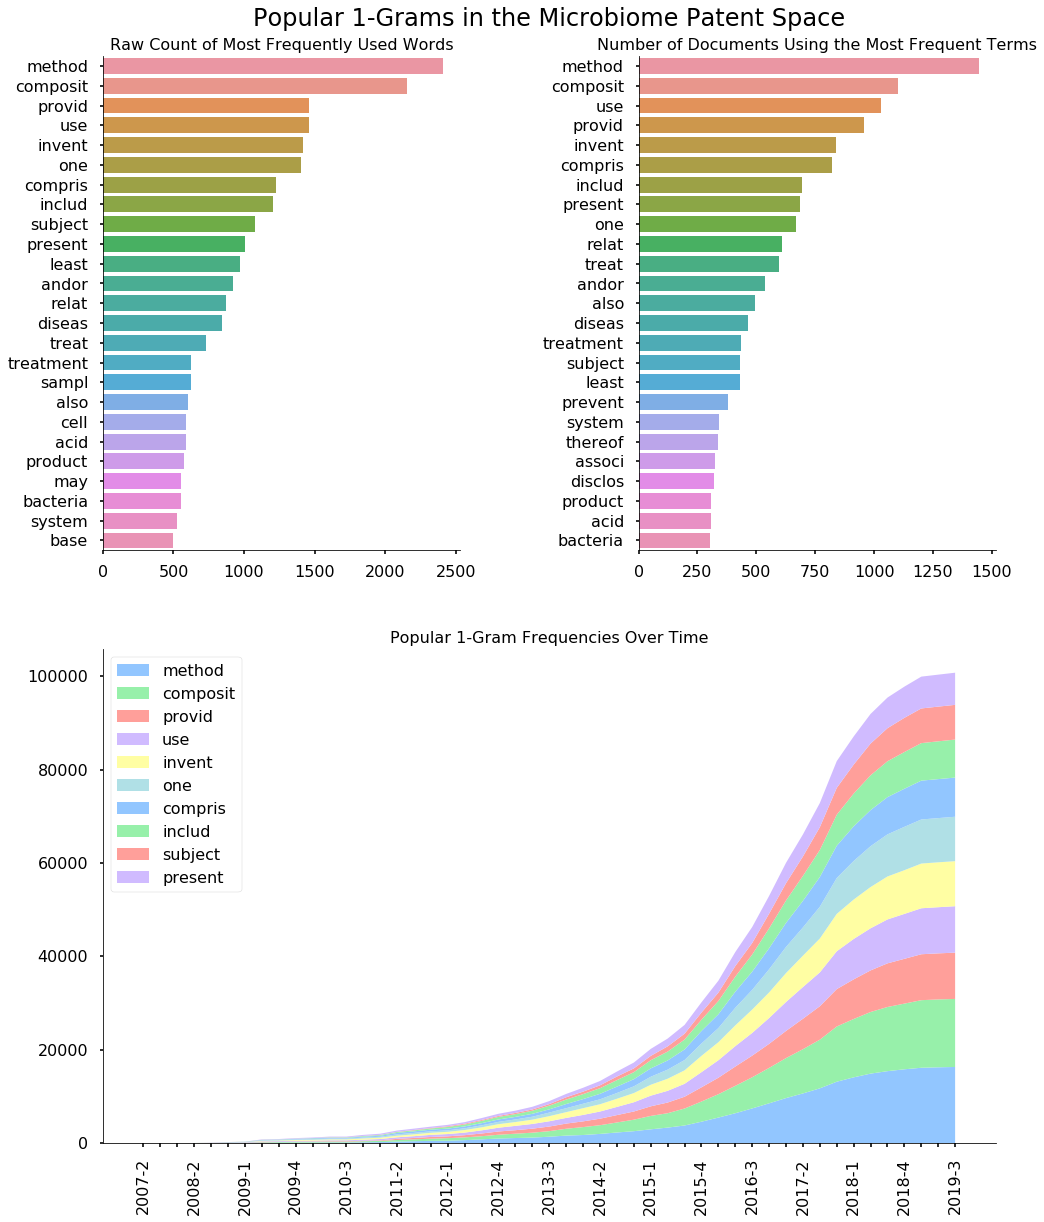

In [63]:
n_gram_analysis(ngram='1', list_of_ngrams = fil_abstracts)

#### 2-Grams

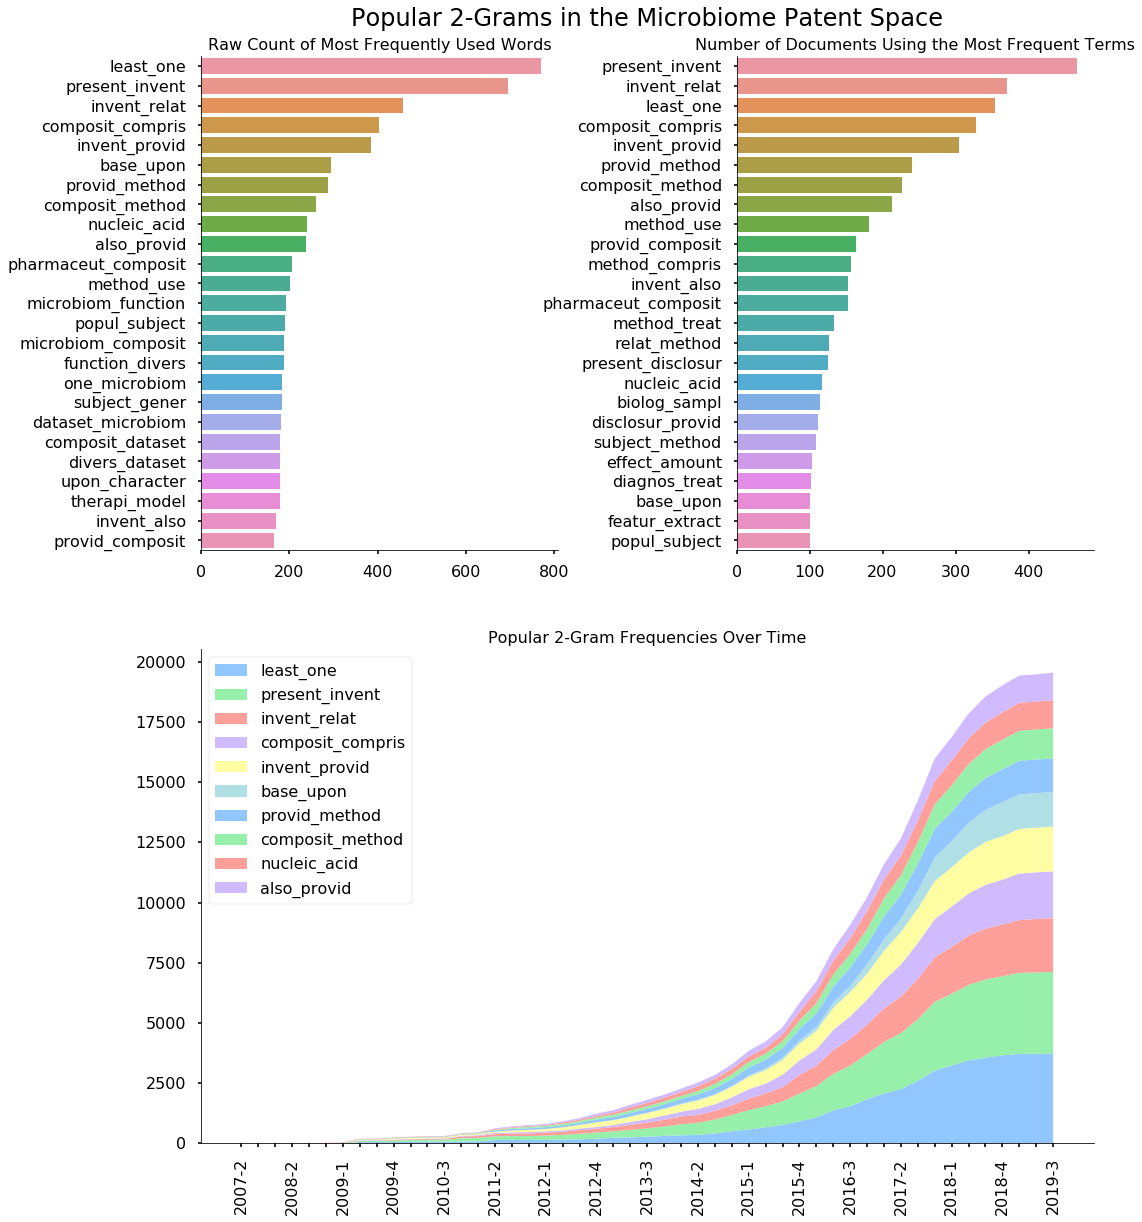

In [64]:
n_gram_analysis(ngram='2', list_of_ngrams = ngrams_2)

#### 3-grams


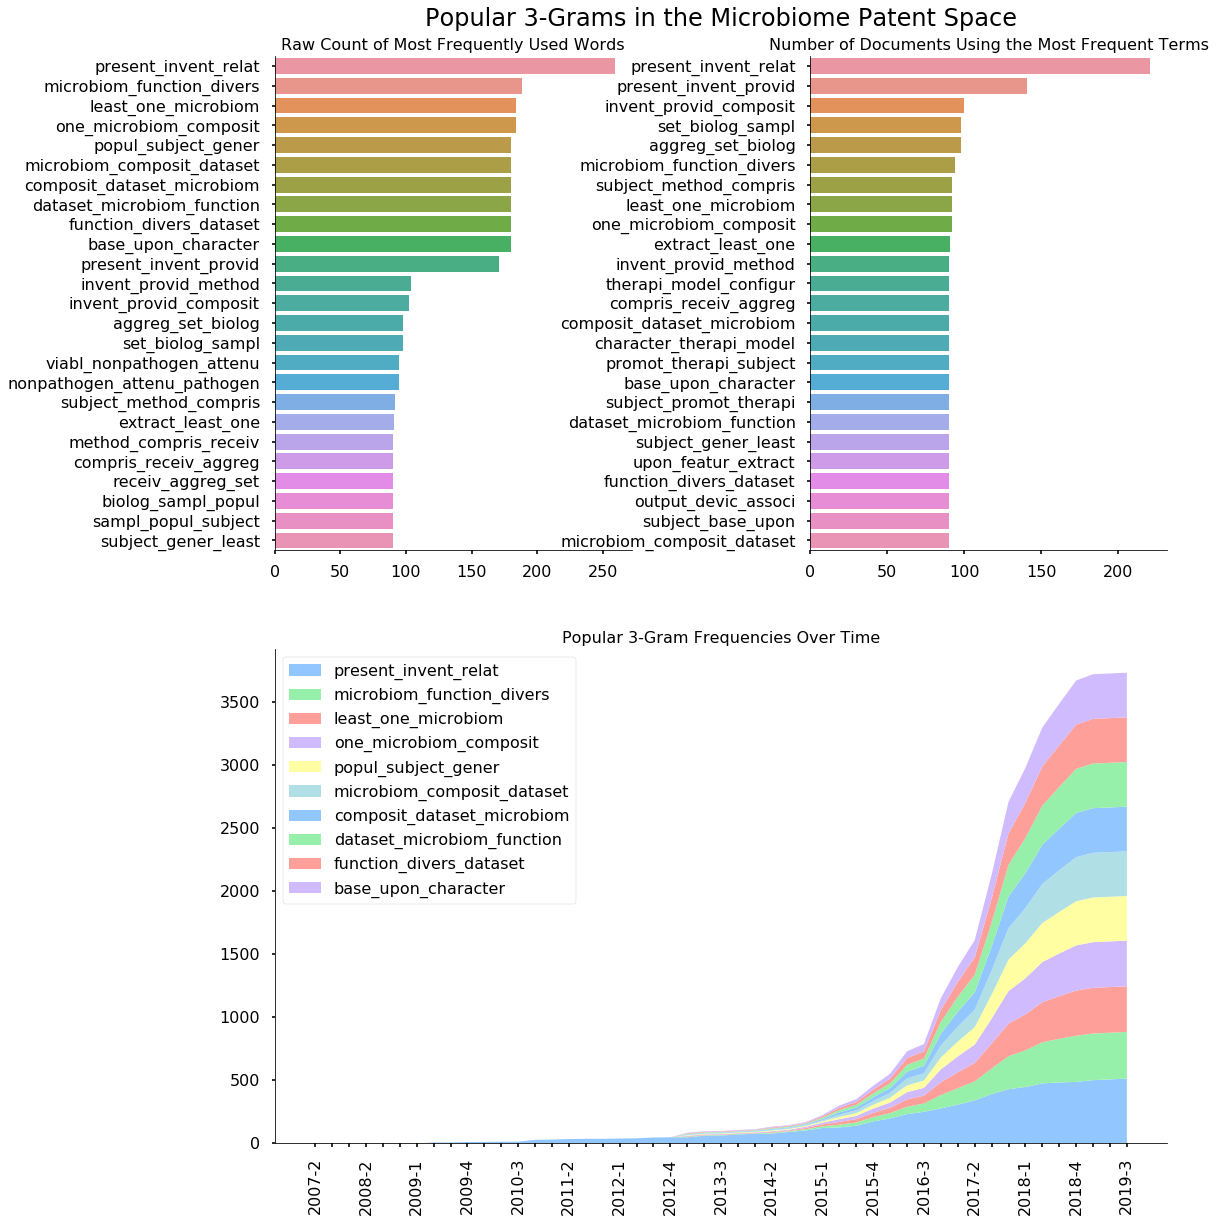

In [65]:
n_gram_analysis(ngram='3', list_of_ngrams = ngrams_3)

### TF-IDF Words 

In [ ]:
tf_dicts = {}

for ngram, list_of_grams in [('1', fil_abstracts), ('2', ngrams_2), ('3', ngrams_3)]:
    for document in list_of_grams:
        for gram in document:
            if gram not in document_dict.keys():
                document_dict[gram] = 1
            else:
                document_dict[gram] += 1
    


In [ ]:

x_values = []
labels = []
for term, term_dict in common_3grams_by_time.items():
    x_values.append(list(term_dict.values()))
    labels.append(term)
    y_values = common_3grams_by_time[term].keys()

### LDA Topic Modeling

Using this as a guide, https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

#### Creating the LDA Models

In [77]:
lda_models = {}
number_topics = 7

for ngram, list_of_grams in tqdm([('1', fil_abstracts), ('2', ngrams_2), ('3', ngrams_3)], total=3):
    print(f'Creating {ngram}-Gram LDA Topic Model with {number_topics} Topics')
    
    count_vectorizer = CountVectorizer(stop_words='english')
    
    count_data = count_vectorizer.fit_transform([' '.join(i) for i in list_of_grams])

    lda = LDA(n_components=number_topics, n_jobs=-1)
    lda.fit(count_data)
    ### Create a dictionary of ID to word mappings
    id2word = corpora.Dictionary(list_of_grams)
    ### Build a corpus that 
    corpus = [id2word.doc2bow(text) for text in list_of_grams]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=number_topics, 
                                               update_every=1,
                                               passes=10,
                                               alpha='symmetric',
                                               iterations=100,
                                               per_word_topics=True)

    for topic in lda_model.print_topics():
        print('\t', topic)
    lda_models[f'{ngram}_model'] = lda_model
    lda_models[f'{ngram}_corpus'] = corpus
    

Creating 1-Gram LDA Topic Model with 7 Topics
	 (0, '0.023*"composit" + 0.021*"method" + 0.014*"compris" + 0.013*"invent" + 0.013*"provid" + 0.012*"product" + 0.011*"use" + 0.011*"present" + 0.010*"includ" + 0.009*"andor"')
	 (1, '0.031*"subject" + 0.026*"microbiom" + 0.024*"character" + 0.024*"dataset" + 0.023*"one" + 0.023*"least" + 0.019*"composit" + 0.019*"base" + 0.018*"gener" + 0.018*"therapi"')
	 (2, '0.022*"method" + 0.021*"one" + 0.018*"includ" + 0.017*"composit" + 0.015*"least" + 0.014*"compris" + 0.011*"provid" + 0.010*"andor" + 0.008*"sampl" + 0.008*"product"')
	 (3, '0.017*"method" + 0.017*"use" + 0.015*"invent" + 0.014*"provid" + 0.014*"composit" + 0.011*"protein" + 0.011*"acid" + 0.011*"cell" + 0.009*"bacteria" + 0.009*"includ"')
	 (4, '0.022*"method" + 0.018*"one" + 0.016*"provid" + 0.015*"includ" + 0.013*"least" + 0.013*"compon" + 0.012*"use" + 0.012*"compris" + 0.011*"devic" + 0.009*"materi"')
	 (5, '0.024*"method" + 0.021*"composit" + 0.015*"use" + 0.015*"invent" + 0

#### LDA Topic Model Word Clouds

A bit of a nicer way to view the topics is as a word cloud. 

In [73]:
def topic_word_cloud(num_topics, lda_model, ngram, max_words = 20, max_font_size = 300):
    cloud = WordCloud(stopwords=stop_words,background_color='white',max_words=max_words)

    topics = lda_model.show_topics(formatted=False)

    grid_rows = int(np.floor(num_topics / 2))

    fig = plt.figure(figsize=(15,15), facecolor='white')
    ax = fig.add_subplot(111, fc='white')    # The big subplot
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    grid = plt.GridSpec(grid_rows, 2, hspace=0.4, wspace=0.3)
    plt.title(f'Word Cloud of Abstract Topics', pad=40, fontsize=24)
    for topic_number, (row_i, col_j) in enumerate(itertools.product(range(0, grid_rows), range(0, 2))):
        ax = fig.add_subplot(grid[row_i, col_j])
        topic_words = dict(topics[topic_number][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(topic_number), fontdict=dict(size=16, fontweight='bold'), pad=20)
        plt.gca().axis('off')

    sns.despine()

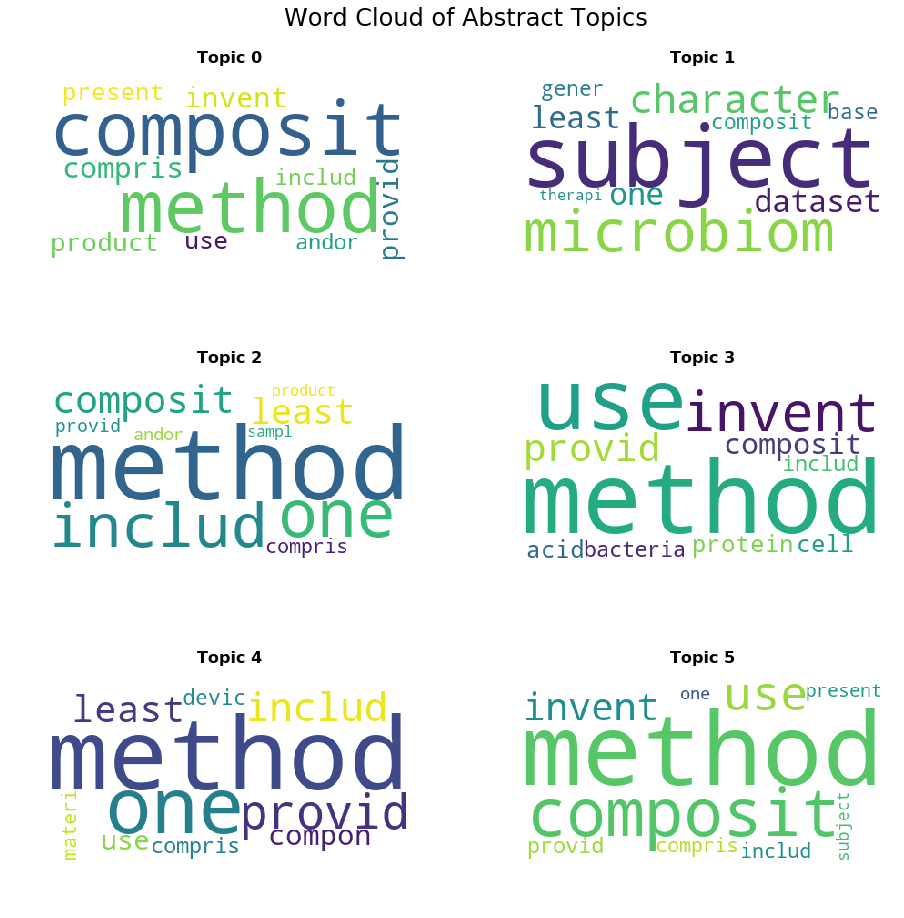

In [78]:
topic_word_cloud(num_topics = number_topics, lda_model = lda_models['1_model'], ngram='1')

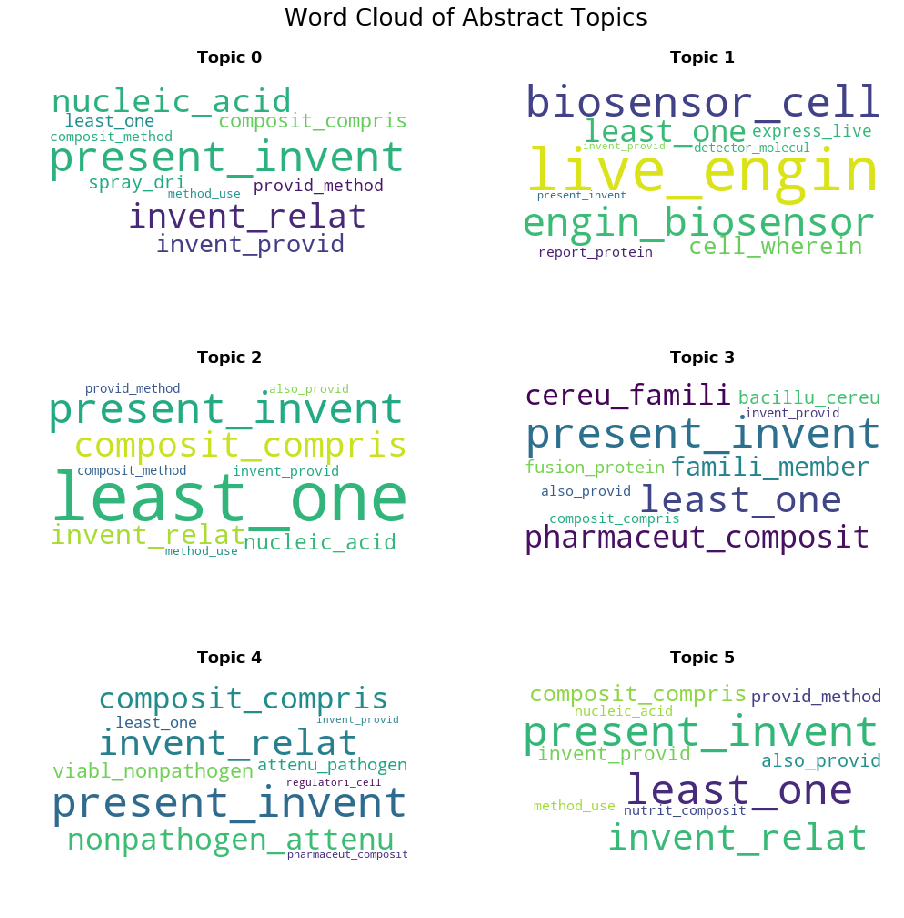

In [74]:
topic_word_cloud(num_topics = number_topics, lda_model = lda_models['2_model'], ngram='2')

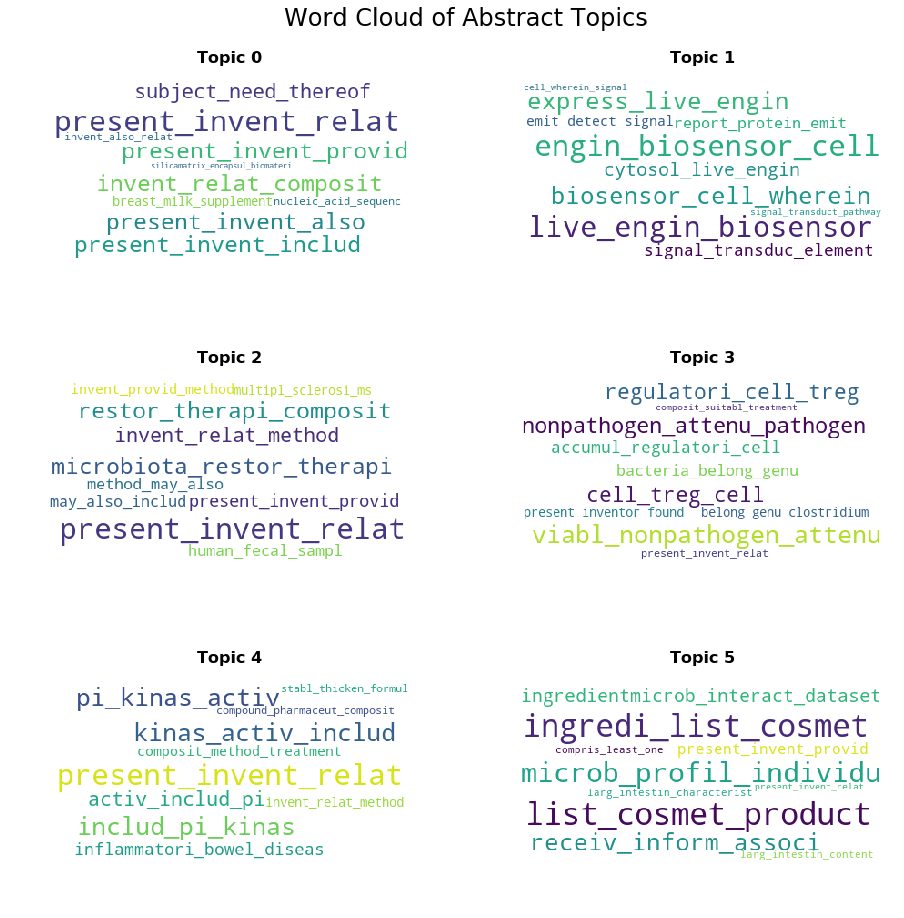

In [75]:
topic_word_cloud(num_topics = number_topics, lda_model = lda_models['3_model'], ngram='3')

#### Dominant Topics

In [92]:
docs_list = []
for ngram, list_of_ngrams in [('1', fil_abstracts), ('2', ngrams_2), ('3', ngrams_3)]:
    for i, doc_rows in enumerate(lda_models[f'{ngram}_corpus']):
        #print(doc_rows)
        doc_row = doc_rows[0] if lda_models[f'{ngram}_model'].per_word_topics else doc_rows
        print(doc_row)
        #doc_row = doc_row[0]#sorted(doc_row, key=lambda x: (x[1]), reverse=True)[0]
        wp = lda_models[f'{ngram}_model'].show_topic(doc_row[0])
        topic_keywords = ", ".join([word for word, prop in wp])
        doc_list = [int(doc_row[0]), round(doc_row[1],4), topic_keywords]
        docs_list.append(doc_list)

docs_list = [i + [j, ngram] for i, j in zip(docs_list, )]
dominant_topic_col = ['dominant_topic_num', 'topic_contribution', 'keywords', 'original_text', 'ngram']
dominant_topic_df = pd.DataFrame(docs_list, columns=dominant_topic_col)
dominant_topic_df.head()

(0, 35)
(0, 21)
(0, 119)
(0, 49)
(100, 1)


IndexError: index 100 is out of bounds for axis 0 with size 7

#### Word Counts by Topic

In [ ]:
doc_lens = [len(d) for d in dominant_topic_df['original_text']]
doc_topic_lens = [(len(d), topic) for (d, topic) in zip(dominant_topic_df['original_text'], dominant_topic_df['dominant_topic_num'])]

In [ ]:
grid_rows = int(np.floor(num_topics / 2) + 1)
bin_size = 5


fig = plt.figure(figsize=(23,20), facecolor='white')
ax = fig.add_subplot(111, fc='white')    # The big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

grid = plt.GridSpec(grid_rows, 2, hspace=0.4, wspace=0.3)
plt.title('Word Count Distribution of Abstracts', pad=30, fontsize=24)
ax1 = fig.add_subplot(grid[0,:])
sns.distplot(doc_lens, bins=len(doc_lens) // bin_size, ax=ax1, kde=False, color = cols[0])
ax1.set(xlabel='Abstract Word Count')
for topic_number, (row_i, col_j) in enumerate(itertools.product(range(1, grid_rows), range(0, 2))):
    ax = fig.add_subplot(grid[row_i,col_j])
    trunc_topic_list = [i[0] for i in doc_topic_lens if i[1] == topic_number]
    sns.distplot(trunc_topic_list, bins=len(trunc_topic_list) // bin_size, ax=ax, kde=False, color=cols[topic_number + 1])
    ax.set_title(f'WC Distribution of Topic: {topic_number}')
    if row_i +1 == grid_rows:
        ax.set(xlabel='Abstract Word Count')
sns.despine()